# Use Wisonsin Breast Cancer data set (Kaggle) to predict whether a tumor will be malignant or benign.

>Approach:
This is a clean data set without ny missing values and is good for the purpose of focusing on learning machine learning techniques. No real manipulation (expect for changing the target variable from 'M', 'B, to 1,0 and adjusting one of the column headers to remove whitespace. The Data set was used in the existing work: K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34.


>A Random Forrest was run on the entire data set to select feature set 1, feature set 2 was chosen at random, feature set 3 was what the authors of the paper mentioned above found to get the best results. Patsy was used to set up the feature sets, test_train_split was used to create a training and a test set.

>Three classification algorithms were used: Logistic Regression, K-Nearest Neighbors, and Random Forrest. Scoring method was 'roc_auc'.
>1. Run Grid search on each feature set using the current algorithm. 
>2. Run a fit on the training set using the grid search parameters.
>3. Run a predict using the fitted model and the test set.
>4. Run a Cross Validaiton to check the results.
>5. Rank the reatures (did not do this for KNN).
>6. Create a confusion matrix and calculate the accuracy, misclasification rate, precision, and recall. 


>Charting
>1. Histograms, boxplots, and violin plots were used to show the distribution of the feture sets.
>2. Bar charts were used to show the scores of the Grid Serach, fit, predict, and cross-validation. 
>3. Bar charts were used for Confusion Matrix results and confusion matrix calculations.

> Notes: Much of the repetitive code was brought into reuseable functions, but this may have over-complicated the project (harder to read, more time spent on efficiency than on data science).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import math
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import patsy
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
%matplotlib inline

C:\Users\danke_000\Anaconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\danke_000\Anaconda3\envs\py2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Comment for below: Read the csv file as a data frame, rename some columns, change the target from a letter code to 1 or 0. Display the head of the data frame. 

In [2]:
df = pd.read_csv('data_breast_cancer.csv')
df.rename(columns={'concave points_mean': 'concave_points_mean', 'concave points_se': 'concave_points_se',
                'concave points_worst': 'concave_points_worst'}, inplace=True)
df.diagnosis.replace(('M', 'B'), (1, 0), inplace=True)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


The cell below sets up a test and training set using patsy and train_test_split

In [3]:
#This is for feature extraction for Random Forest Feature Extraction
col_names = df.columns
end_col = col_names[-2]
col_names = col_names[2:-2]
formula_huge = 'diagnosis ~ '
for name in col_names:
    formula_huge += name + ' + '
formula_huge += end_col

y_6, x_6 = patsy.dmatrices(formula_huge, df, return_type='dataframe')
y_6 = df['diagnosis']
train_x_6, test_x_6, train_y_6, test_y_6 = train_test_split(x_6, y_6, train_size=0.75)

Below:  
1- Set up the Random Forrest algorithm  
2- Perform a fit with the training set  
3- Score the fit  
4- Run a prediction  
5- score the prediction against the fit

In [4]:
#Random Forrest (uses train set fot fit and test set for predict) - Feature Selection
print "Random Forrest results:"
rnd_frst_big = RandomForestClassifier(n_estimators = 500)
rf_model_big = rnd_frst_big.fit(train_x_6, train_y_6)
score_rf_big = rf_model_big.score(train_x_6, train_y_6)
rf_pred_big = rf_model_big.predict(test_x_6)
score_rf_big_pred = rf_model_big.score(test_x_6, test_y_6)
print "score of fit: " + str(score_rf_big)
print "score of prediction: " + str(score_rf_big_pred)

Random Forrest results:
score of fit: 1.0
score of prediction: 0.986013986014


Below:  
1- Pull the most influential features from the fitted random forrest model  
2- Put them into a dataframe  
3- Sort the dataframe

In [5]:
#Feature importance random forest
rf_cols_big = []
for col in x_6.columns:
    rf_cols_big.append(col + '_rf_big')
#rf_cols = rf_cols[1:]

rf_big_feature_importances = rf_model_big.feature_importances_
features_df_big = pd.DataFrame({'Features_set_6': rf_cols_big, 'rf_big_Importance Score': rf_big_feature_importances})
features_df_big.sort_values('rf_big_Importance Score', inplace=True, ascending=False)
print "Feature Importance:"
features_df_big.head()

Feature Importance:


,Features_set_6,rf_big_Importance Score
8,concave_points_mean_rf_big,0.121791
28,concave_points_worst_rf_big,0.119385
21,radius_worst_rf_big,0.108884
23,perimeter_worst_rf_big,0.106115
24,area_worst_rf_big,0.091871


Below:  
Create a correlation matix for all features (all columns in original dataset)

In [6]:
#Correlation Matrix...same as covariance matrix?
cols_to_keep = df.columns[2:32]
df_cols = df[cols_to_keep]
df_corr = df_cols.corr()
df_corr

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave_points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Below is a Heatmap of the Correlation Matrix

Axes(0.125,0.125;0.62x0.755)


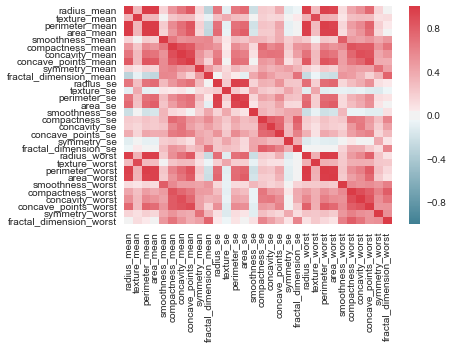

In [7]:
#Heatmap of Correlation Matrix
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print sns.heatmap(df_corr, cmap=cmap)

In [8]:
#df_corr.idxmax()

In [9]:
#df_corr['radius_mean'].max().index
#index_result = df_corr.loc[df_corr['radius_mean' > 0 0.822529]]
#index_result

Code below is sufficiently commented.

In [10]:
#Create various patsy formulas and set up some train/test sets. The first set is from the feature selection phase (where the random forrest 
#algorithm was used, the second feature set was chosen at random, and the third set are the authors (K. P. Bennett and O. L. Mangasarian)
#found to work well.


#Feature set 1 - These are the top 5 from the random forrest that was run on the entire feature set
formula_1 = 'diagnosis ~ perimeter_worst + concave_points_mean + concave_points_worst + area_worst + radius_worst'
y_1, x_1 = patsy.dmatrices(formula_1, df, return_type='dataframe')
y_1 = y_1.values.ravel()
train_x_1, test_x_1, train_y_1, test_y_1 = train_test_split(x_1, y_1, train_size=0.75)

#Feature set 2 - Chosen at random 
formula_2 = 'diagnosis ~ radius_mean + texture_mean + perimeter_mean'
y_2, x_2 = patsy.dmatrices(formula_2, df, return_type='dataframe')
y_2 = y_2.values.ravel()
train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(x_2, y_2, train_size=0.75)

#Feature set 3 - This is the feature combination found by the authors to work the best
formula_gold = 'diagnosis ~ area_worst + smoothness_worst + texture_mean'
y_3, x_3 = patsy.dmatrices(formula_gold, df, return_type='dataframe')
y_3 = df['diagnosis']
train_x_3, test_x_3, train_y_3, test_y_3 = train_test_split(x_3, y_3, train_size=0.75)

#--------------------------------------------------------------------------------------------#
#Feature set 1 - These are the top 5 from the random forrest that was run on the entire feature set
#Features need to be scaled for logistic regression. Below are the same 3 feature sets but scalled prior to splitting.
ss = StandardScaler()
#Create temp df to hold target values
df_y_temp = df['diagnosis']
#Created a dataframe for the patsy. First it only has the features, which will be scaled.
col_list_x1_ss = ['perimeter_worst','concave_points_mean', 'concave_points_worst', 'area_worst', 'radius_worst']
df_ss_set_1 = df[col_list_x1_ss]
#Scaling performed at the dataframe level. Numpy, scikit, and pandas all trying to work together
df_ss_set_1[col_list_x1_ss] = ss.fit_transform(df_ss_set_1[col_list_x1_ss])
#add the target variables to the dataframe for the patsy.
df_ss_set_1['diagnosis'] = df_y_temp
formula_1 = 'diagnosis ~ perimeter_worst + concave_points_mean + concave_points_worst + area_worst + radius_worst'
y_1_ss, x_1_ss = patsy.dmatrices(formula_1, df_ss_set_1, return_type='dataframe')
y_1_ss = y_1_ss.values.ravel()
train_x_1_ss, test_x_1_ss, train_y_1_ss, test_y_1_ss = train_test_split(x_1_ss, y_1_ss, train_size=0.75)


#Feature set 2 - Chosen at random 
#Create temp df to hold target values
df_y_temp = df['diagnosis']
col_list_x2_ss = ['radius_mean', 'texture_mean', 'perimeter_mean']
df_ss_set_2 = df[col_list_x2_ss]
#Scaling performed at the dataframe level. Numpy, scikit, and pandas all trying to work together
df_ss_set_2[col_list_x2_ss] = ss.fit_transform(df_ss_set_2[col_list_x2_ss])
#add the target variables to the dataframe for the patsy.
df_ss_set_2['diagnosis'] = df_y_temp
formula_2 = 'diagnosis ~ radius_mean + texture_mean + perimeter_mean'
y_2_ss, x_2_ss = patsy.dmatrices(formula_2, df_ss_set_2, return_type='dataframe')
y_2_ss = y_2_ss.values.ravel()
train_x_2_ss, test_x_2_ss, train_y_2_ss, test_y_2_ss = train_test_split(x_2_ss, y_2_ss, train_size=0.75)


#Feature set 3 - This is the feature combination found by the authors to work the best
#Create temp df to hold target values
df_y_temp = df['diagnosis']
col_list_x3_ss = ['area_worst', 'smoothness_worst', 'texture_mean']
df_ss_set_3 = df[col_list_x3_ss]
#Scaling performed at the dataframe level. Numpy, scikit, and pandas all trying to work together
df_ss_set_3[col_list_x3_ss] = ss.fit_transform(df_ss_set_3[col_list_x3_ss])
#add the target variables to the dataframe for the patsy.
df_ss_set_3['diagnosis'] = df_y_temp
formula_gold = 'diagnosis ~ area_worst + smoothness_worst + texture_mean'
y_3_ss, x_3_ss = patsy.dmatrices(formula_gold, df_ss_set_3, return_type='dataframe')
y_3_ss = y_3_ss.values.ravel()
train_x_3_ss, test_x_3_ss, train_y_3_ss, test_y_3_ss = train_test_split(x_3_ss, y_3_ss, train_size=0.75)


C:\Users\danke_000\Anaconda3\envs\py2\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\danke_000\Anaconda3\envs\py2\lib\site-packages\pandas\core\frame.py:2454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\danke_000\Anaconda3\envs\py2\lib\site-packages\pandas\core\frame.py:2424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

Below is some charting using standard matplotlib (histogram, boxplot, violin plot). Sufficiently commented already.

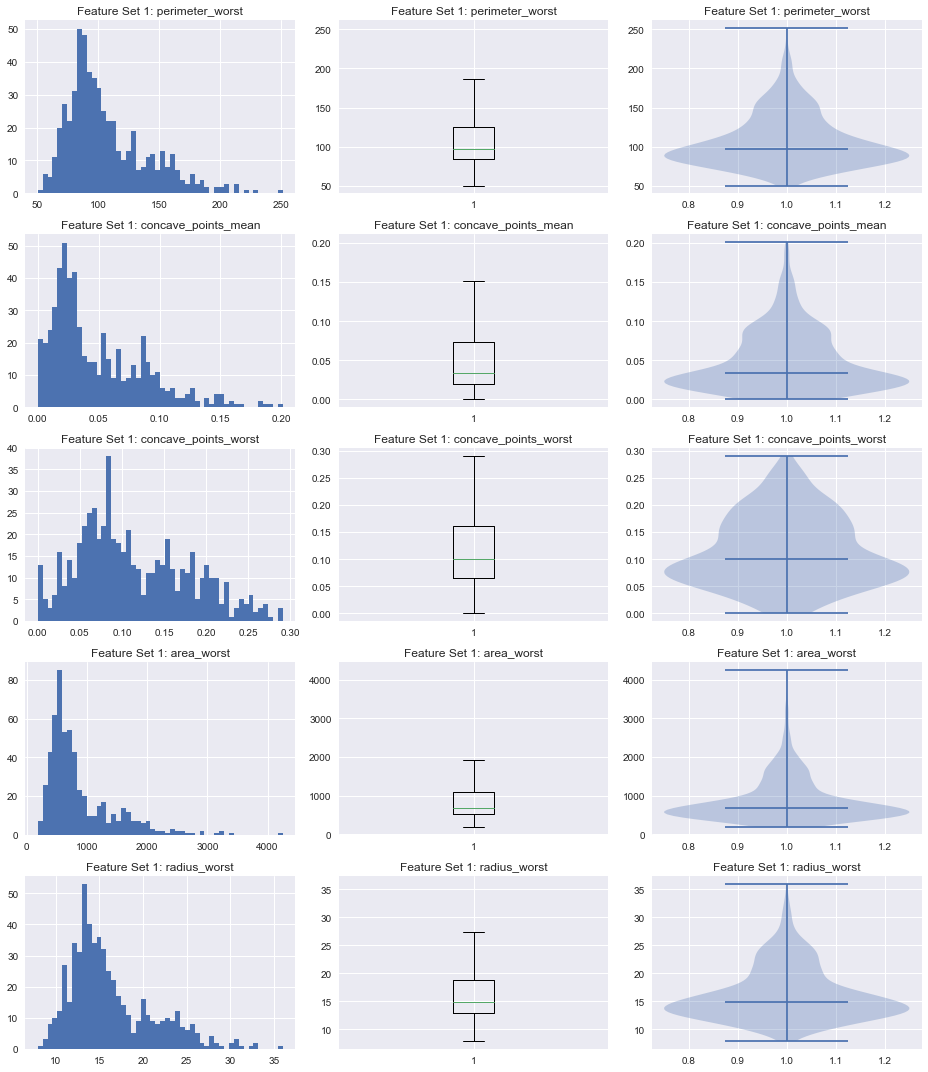

In [11]:
#Histograms, boxplots, amd violin plots: Feature set 1
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(13)
ax1 = fig.add_subplot(5,3,1)
_ = ax1.hist(df['perimeter_worst'], bins=50)
ax1.set_title('Feature Set 1: perimeter_worst')

ax2 = fig.add_subplot(5,3,2)
_ = ax2.boxplot(df['perimeter_worst'])
ax2.set_title('Feature Set 1: perimeter_worst')

ax3 = fig.add_subplot(5,3,3)
_ = ax3.violinplot(df['perimeter_worst'], showmeans=False, showmedians=True)
ax3.set_title('Feature Set 1: perimeter_worst')

ax4 = fig.add_subplot(5,3,4)
_ = ax4.hist(df['concave_points_mean'], bins=50)
ax4.set_title('Feature Set 1: concave_points_mean')

ax5 = fig.add_subplot(5,3,5)
_ = ax5.boxplot(df['concave_points_mean'])
ax5.set_title('Feature Set 1: concave_points_mean')

ax6 = fig.add_subplot(5,3,6)
_ = ax6.violinplot(df['concave_points_mean'], showmeans=False, showmedians=True)
ax6.set_title('Feature Set 1: concave_points_mean')

ax7 = fig.add_subplot(5,3,7)
_ = ax7.hist(df['concave_points_worst'], bins=50)
ax7.set_title('Feature Set 1: concave_points_worst')

ax8 = fig.add_subplot(5,3,8)
_ = ax8.boxplot(df['concave_points_worst'])
ax8.set_title('Feature Set 1: concave_points_worst')

ax9 = fig.add_subplot(5,3,9)
_ = ax9.violinplot(df['concave_points_worst'], showmeans=False, showmedians=True)
ax9.set_title('Feature Set 1: concave_points_worst')

ax10 = fig.add_subplot(5,3,10)
_ = ax10.hist(df['area_worst'], bins=50)
ax10.set_title('Feature Set 1: area_worst')

ax11 = fig.add_subplot(5,3,11)
_ = ax11.boxplot(df['area_worst'])
ax11.set_title('Feature Set 1: area_worst')

ax12 = fig.add_subplot(5,3,12)
_ = ax12.violinplot(df['area_worst'], showmeans=False, showmedians=True)
ax12.set_title('Feature Set 1: area_worst')

ax13 = fig.add_subplot(5,3,13)
_ = ax13.hist(df['radius_worst'], bins=50)
ax13.set_title('Feature Set 1: radius_worst')

ax14 = fig.add_subplot(5,3,14)
_ = ax14.boxplot(df['radius_worst'])
ax14.set_title('Feature Set 1: radius_worst')

ax15 = fig.add_subplot(5,3,15)
_ = ax15.violinplot(df['radius_worst'], showmeans=False, showmedians=True)
ax15.set_title('Feature Set 1: radius_worst')

plt.tight_layout()

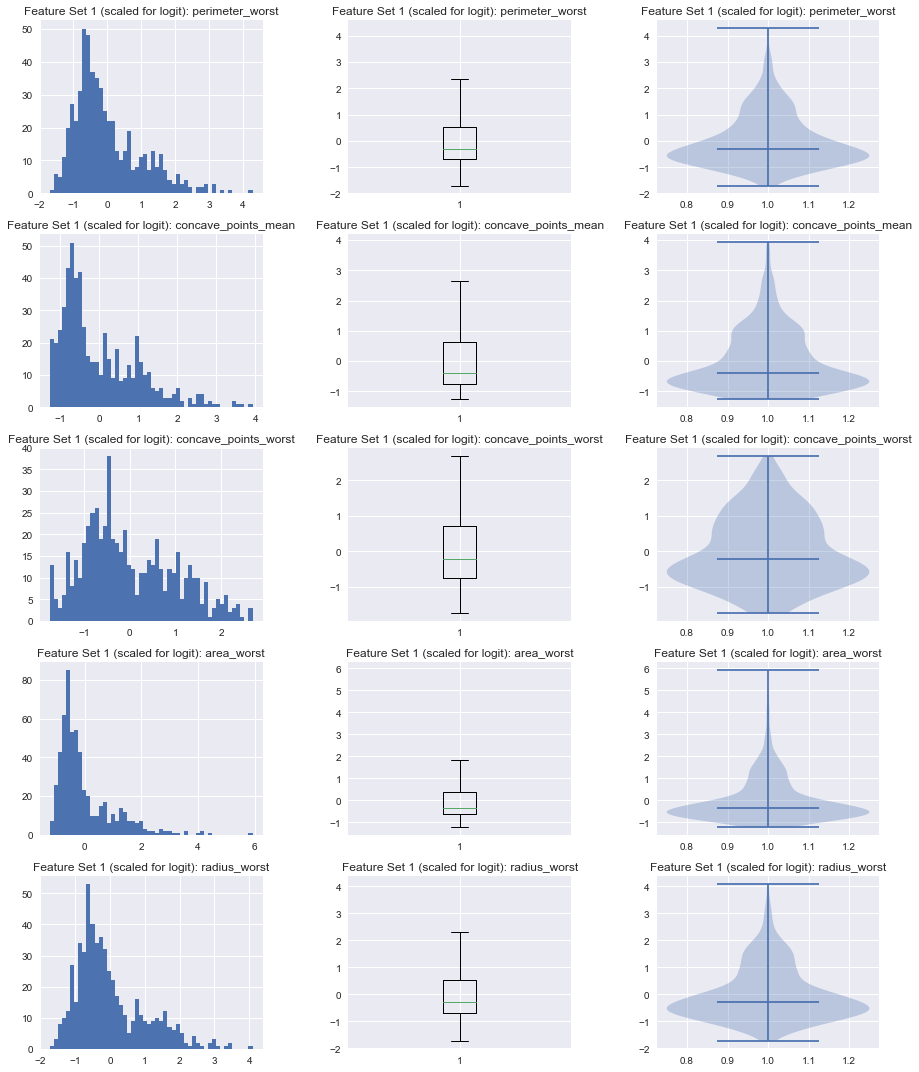

In [12]:
#Histograms, boxplots, amd violin plots: Feature set 1 (scaled for logit)
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(13)
ax1 = fig.add_subplot(5,3,1)
_ = ax1.hist(df_ss_set_1['perimeter_worst'], bins=50)
ax1.set_title('Feature Set 1 (scaled for logit): perimeter_worst')

ax2 = fig.add_subplot(5,3,2)
_ = ax2.boxplot(df_ss_set_1['perimeter_worst'])
ax2.set_title('Feature Set 1 (scaled for logit): perimeter_worst')

ax3 = fig.add_subplot(5,3,3)
_ = ax3.violinplot(df_ss_set_1['perimeter_worst'], showmeans=False, showmedians=True)
ax3.set_title('Feature Set 1 (scaled for logit): perimeter_worst')

ax4 = fig.add_subplot(5,3,4)
_ = ax4.hist(df_ss_set_1['concave_points_mean'], bins=50)
ax4.set_title('Feature Set 1 (scaled for logit): concave_points_mean')

ax5 = fig.add_subplot(5,3,5)
_ = ax5.boxplot(df_ss_set_1['concave_points_mean'])
ax5.set_title('Feature Set 1 (scaled for logit): concave_points_mean')

ax6 = fig.add_subplot(5,3,6)
_ = ax6.violinplot(df_ss_set_1['concave_points_mean'], showmeans=False, showmedians=True)
ax6.set_title('Feature Set 1 (scaled for logit): concave_points_mean')

ax7 = fig.add_subplot(5,3,7)
_ = ax7.hist(df_ss_set_1['concave_points_worst'], bins=50)
ax7.set_title('Feature Set 1 (scaled for logit): concave_points_worst')

ax8 = fig.add_subplot(5,3,8)
_ = ax8.boxplot(df_ss_set_1['concave_points_worst'])
ax8.set_title('Feature Set 1 (scaled for logit): concave_points_worst')

ax9 = fig.add_subplot(5,3,9)
_ = ax9.violinplot(df_ss_set_1['concave_points_worst'], showmeans=False, showmedians=True)
ax9.set_title('Feature Set 1 (scaled for logit): concave_points_worst')

ax10 = fig.add_subplot(5,3,10)
_ = ax10.hist(df_ss_set_1['area_worst'], bins=50)
ax10.set_title('Feature Set 1 (scaled for logit): area_worst')

ax11 = fig.add_subplot(5,3,11)
_ = ax11.boxplot(df_ss_set_1['area_worst'])
ax11.set_title('Feature Set 1 (scaled for logit): area_worst')

ax12 = fig.add_subplot(5,3,12)
_ = ax12.violinplot(df_ss_set_1['area_worst'], showmeans=False, showmedians=True)
ax12.set_title('Feature Set 1 (scaled for logit): area_worst')

ax13 = fig.add_subplot(5,3,13)
_ = ax13.hist(df_ss_set_1['radius_worst'], bins=50)
ax13.set_title('Feature Set 1 (scaled for logit): radius_worst')

ax14 = fig.add_subplot(5,3,14)
_ = ax14.boxplot(df_ss_set_1['radius_worst'])
ax14.set_title('Feature Set 1 (scaled for logit): radius_worst')

ax15 = fig.add_subplot(5,3,15)
_ = ax15.violinplot(df_ss_set_1['radius_worst'], showmeans=False, showmedians=True)
ax15.set_title('Feature Set 1 (scaled for logit): radius_worst')

plt.tight_layout()

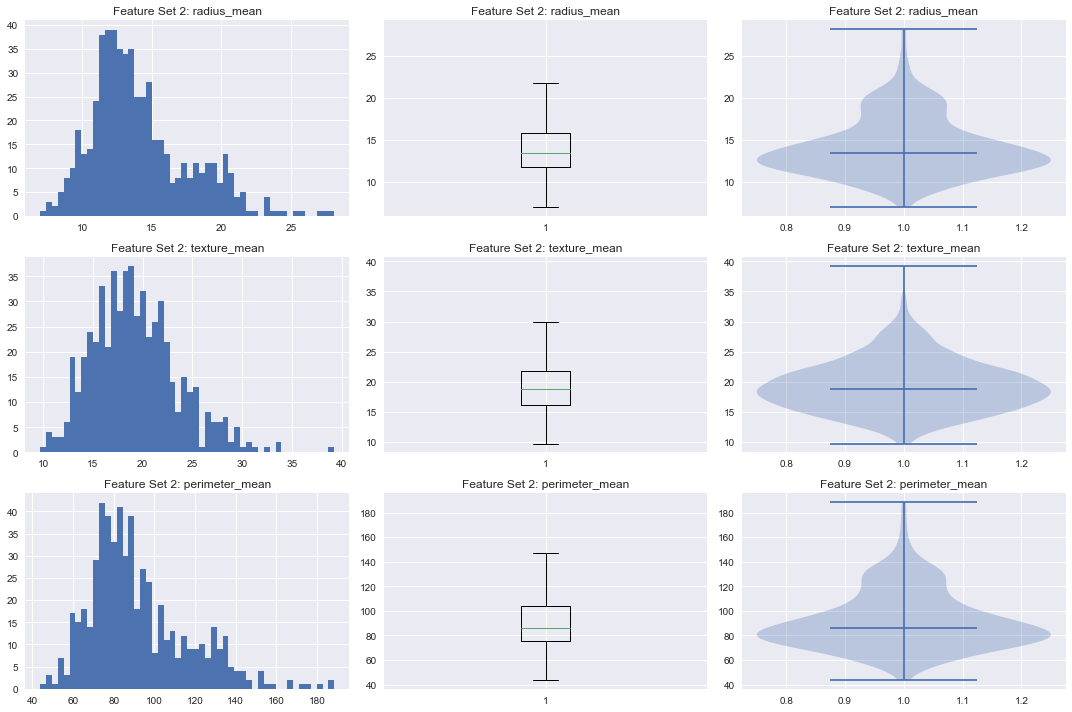

In [13]:
#Histograms, boxplots, amd violin plots: Feature set 2
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax1 = fig.add_subplot(3,3,1)
_ = ax1.hist(df['radius_mean'], bins=50)
ax1.set_title('Feature Set 2: radius_mean')

ax2 = fig.add_subplot(3,3,2)
_ = ax2.boxplot(df['radius_mean'])
ax2.set_title('Feature Set 2: radius_mean')

ax3 = fig.add_subplot(3,3,3)
_ = ax3.violinplot(df['radius_mean'], showmeans=False, showmedians=True)
ax3.set_title('Feature Set 2: radius_mean')

ax4 = fig.add_subplot(3,3,4)
_ = ax4.hist(df['texture_mean'], bins=50)
ax4.set_title('Feature Set 2: texture_mean')

ax5 = fig.add_subplot(3,3,5)
_ = ax5.boxplot(df['texture_mean'])
ax5.set_title('Feature Set 2: texture_mean')

ax6 = fig.add_subplot(3,3,6)
_ = ax6.violinplot(df['texture_mean'], showmeans=False, showmedians=True)
ax6.set_title('Feature Set 2: texture_mean')

ax7 = fig.add_subplot(3,3,7)
_ = ax7.hist(df['perimeter_mean'], bins=50)
ax7.set_title('Feature Set 2: perimeter_mean')

ax8 = fig.add_subplot(3,3,8)
_ = ax8.boxplot(df['perimeter_mean'])
ax8.set_title('Feature Set 2: perimeter_mean')

ax9 = fig.add_subplot(3,3,9)
_ = ax9.violinplot(df['perimeter_mean'], showmeans=False, showmedians=True)
ax9.set_title('Feature Set 2: perimeter_mean')

plt.tight_layout()


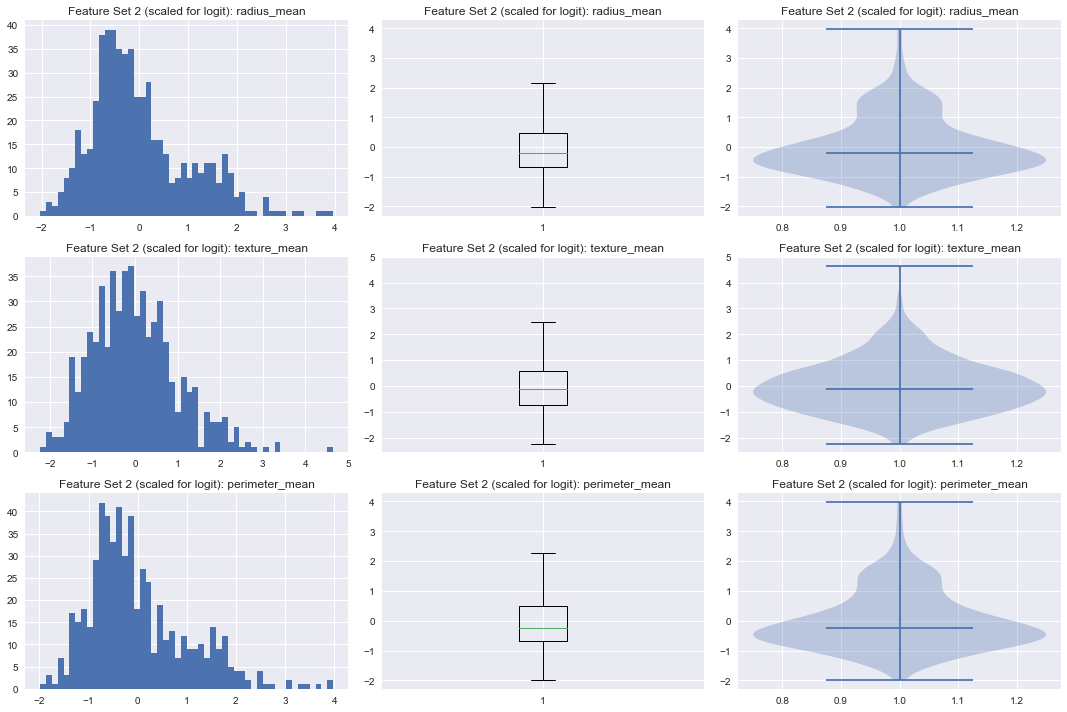

In [14]:
#Histograms, boxplots, amd violin plots: Feature set 2 (scaled for logit)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax1 = fig.add_subplot(3,3,1)
_ = ax1.hist(df_ss_set_2['radius_mean'], bins=50)
ax1.set_title('Feature Set 2 (scaled for logit): radius_mean')

ax2 = fig.add_subplot(3,3,2)
_ = ax2.boxplot(df_ss_set_2['radius_mean'])
ax2.set_title('Feature Set 2 (scaled for logit): radius_mean')

ax3 = fig.add_subplot(3,3,3)
_ = ax3.violinplot(df_ss_set_2['radius_mean'], showmeans=False, showmedians=True)
ax3.set_title('Feature Set 2 (scaled for logit): radius_mean')

ax4 = fig.add_subplot(3,3,4)
_ = ax4.hist(df_ss_set_2['texture_mean'], bins=50)
ax4.set_title('Feature Set 2 (scaled for logit): texture_mean')

ax5 = fig.add_subplot(3,3,5)
_ = ax5.boxplot(df_ss_set_2['texture_mean'])
ax5.set_title('Feature Set 2 (scaled for logit): texture_mean')

ax6 = fig.add_subplot(3,3,6)
_ = ax6.violinplot(df_ss_set_2['texture_mean'], showmeans=False, showmedians=True)
ax6.set_title('Feature Set 2 (scaled for logit): texture_mean')

ax7 = fig.add_subplot(3,3,7)
_ = ax7.hist(df_ss_set_2['perimeter_mean'], bins=50)
ax7.set_title('Feature Set 2 (scaled for logit): perimeter_mean')

ax8 = fig.add_subplot(3,3,8)
_ = ax8.boxplot(df_ss_set_2['perimeter_mean'])
ax8.set_title('Feature Set 2 (scaled for logit): perimeter_mean')

ax9 = fig.add_subplot(3,3,9)
_ = ax9.violinplot(df_ss_set_2['perimeter_mean'], showmeans=False, showmedians=True)
ax9.set_title('Feature Set 2 (scaled for logit): perimeter_mean')

plt.tight_layout()


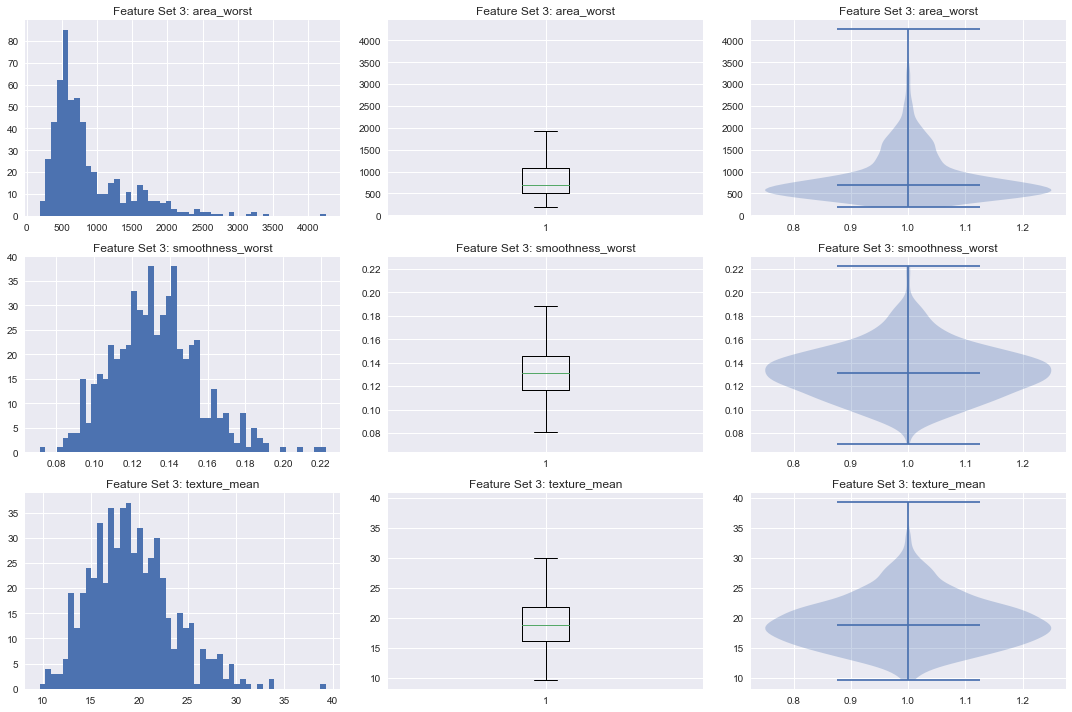

In [15]:
#Histograms, boxplots, amd violin plots: Feature set 3
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax1 = fig.add_subplot(3,3,1)
_ = ax1.hist(df['area_worst'], bins=50)
ax1.set_title('Feature Set 3: area_worst')

ax2 = fig.add_subplot(3,3,2)
_ = ax2.boxplot(df['area_worst'])
ax2.set_title('Feature Set 3: area_worst')

ax3 = fig.add_subplot(3,3,3)
_ = ax3.violinplot(df['area_worst'], showmeans=False, showmedians=True)
ax3.set_title('Feature Set 3: area_worst')

ax4 = fig.add_subplot(3,3,4)
_ = ax4.hist(df['smoothness_worst'], bins=50)
ax4.set_title('Feature Set 3: smoothness_worst')

ax5 = fig.add_subplot(3,3,5)
_ = ax5.boxplot(df['smoothness_worst'])
ax5.set_title('Feature Set 3: smoothness_worst')

ax6 = fig.add_subplot(3,3,6)
_ = ax6.violinplot(df['smoothness_worst'], showmeans=False, showmedians=True)
ax6.set_title('Feature Set 3: smoothness_worst')

ax7 = fig.add_subplot(3,3,7)
_ = ax7.hist(df['texture_mean'], bins=50)
ax7.set_title('Feature Set 3: texture_mean')

ax8 = fig.add_subplot(3,3,8)
_ = ax8.boxplot(df['texture_mean'])
ax8.set_title('Feature Set 3: texture_mean')

ax9 = fig.add_subplot(3,3,9)
_ = ax9.violinplot(df['texture_mean'], showmeans=False, showmedians=True)
ax9.set_title('Feature Set 3: texture_mean')

plt.tight_layout()

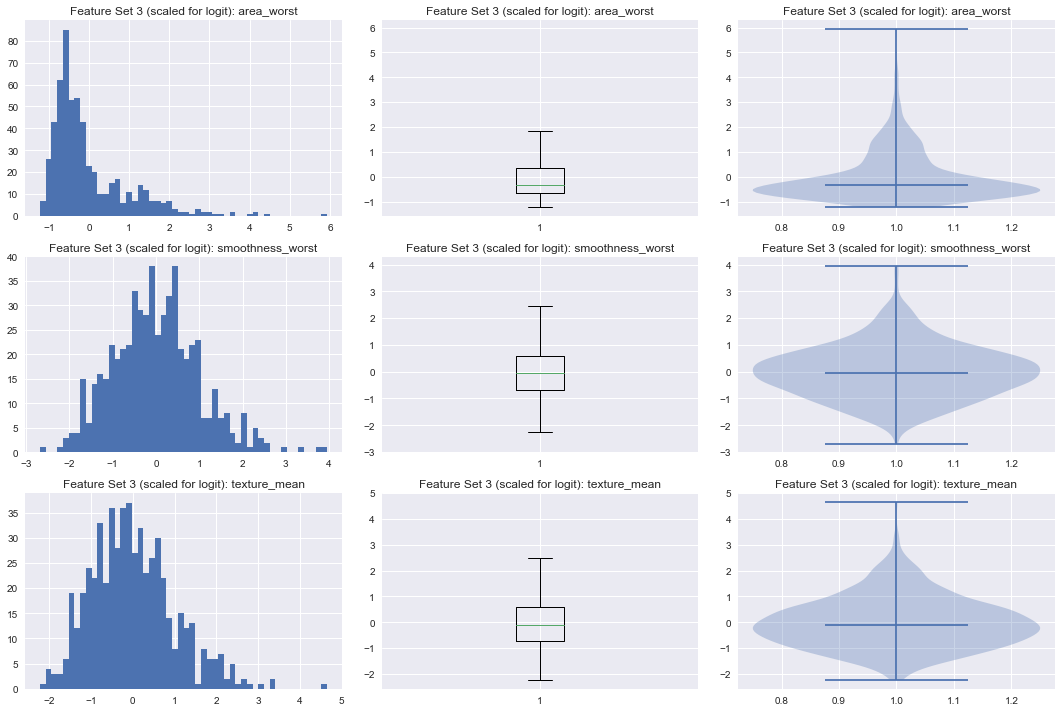

In [16]:
#Histograms, boxplots, amd violin plots: Feature set 3 (scaled for logit)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax1 = fig.add_subplot(3,3,1)
_ = ax1.hist(df_ss_set_3['area_worst'], bins=50)
ax1.set_title('Feature Set 3 (scaled for logit): area_worst')

ax2 = fig.add_subplot(3,3,2)
_ = ax2.boxplot(df_ss_set_3['area_worst'])
ax2.set_title('Feature Set 3 (scaled for logit): area_worst')

ax3 = fig.add_subplot(3,3,3)
_ = ax3.violinplot(df_ss_set_3['area_worst'], showmeans=False, showmedians=True)
ax3.set_title('Feature Set 3 (scaled for logit): area_worst')

ax4 = fig.add_subplot(3,3,4)
_ = ax4.hist(df_ss_set_3['smoothness_worst'], bins=50)
ax4.set_title('Feature Set 3 (scaled for logit): smoothness_worst')

ax5 = fig.add_subplot(3,3,5)
_ = ax5.boxplot(df_ss_set_3['smoothness_worst'])
ax5.set_title('Feature Set 3 (scaled for logit): smoothness_worst')

ax6 = fig.add_subplot(3,3,6)
_ = ax6.violinplot(df_ss_set_3['smoothness_worst'], showmeans=False, showmedians=True)
ax6.set_title('Feature Set 3 (scaled for logit): smoothness_worst')

ax7 = fig.add_subplot(3,3,7)
_ = ax7.hist(df_ss_set_3['texture_mean'], bins=50)
ax7.set_title('Feature Set 3 (scaled for logit): texture_mean')

ax8 = fig.add_subplot(3,3,8)
_ = ax8.boxplot(df_ss_set_3['texture_mean'])
ax8.set_title('Feature Set 3 (scaled for logit): texture_mean')

ax9 = fig.add_subplot(3,3,9)
_ = ax9.violinplot(df_ss_set_3['texture_mean'], showmeans=False, showmedians=True)
ax9.set_title('Feature Set 3 (scaled for logit): texture_mean')

plt.tight_layout()

Below is a function that will run a grid search for paramter optimization.  
Note that the 'algorithm' parameter is where the particular model will be plugged in.

In [17]:
#This function runs a grid search. The function parameters are the algorithm, features, target, and hyperparameters.
def explore_model(params, model, X, y):
    gs = grid_search.GridSearchCV(
        estimator=model,
        cv=5,
        param_grid=params,
        scoring='roc_auc',
        )
    gs.fit(X,y)
    return gs

Similar appraoach below. USe functions to make model fitting, etc. reusable for different scenarios.

In [18]:
#These functions run the model fit, model prediction, and cross-validaiton check.
#Functions used in order to reduce typing and errors.

#Using the training data, score the model fit
def func_model_fit(model, x_train, y_train):
    model_fit = model.fit(x_train, y_train)
    fit_score = model_fit.score(x_train, y_train)
    return fit_score

#Using the training and test data, score the prediction
def func_model_pred(model, x_train, y_train, x_test, y_test):
    model_fit = model.fit(x_train, y_train)
    model_pred = model_fit.predict(x_test)
    pred_score = model_fit.score(x_test, y_test)
    return pred_score

#Using the training data and full set of data, run a cross validation    
def func_cv_check(model, x_train, y_train, x_full, y_full):
    model_fit = model.fit(x_train, y_train)
    mod_scores = cross_val_score(model_fit, x_full, y_full, scoring='roc_auc', cv=5)
    return mod_scores


Run a logistic regression, knn, and random forrest, with the hope of demonstrating the best algorithm. For each algorithm, 1) run a grid search 2) run fit, predict, and cross validaiton on the algorithm with the hyperparameters determined from the grid search, 3) classification report 4) feature importance evaluation. 

In [19]:
#Logistic Regression Model Exploration
lr_model_gs = LogisticRegression()
lr_params = {"C":[0.1, 0.2, 0.4], 'penalty':['l1','l2']} 

In [20]:
#Feature Set 1
#Logistic Regression Model Exploration for feature set 1
logit_explore_1 = explore_model(lr_params, lr_model_gs, x_1_ss, y_1_ss)

print "Logistic Regression Model Exploration"
print "best gs score:"
print logit_explore_1.best_score_
print ""
print "best gs params:"
print logit_explore_1.best_params_


Logistic Regression Model Exploration
best gs score:
0.988342601076

best gs params:
{'penalty': 'l1', 'C': 0.4}


In [21]:
#Logistic Regression Model Exploration for feature set 2
logit_explore_2 = explore_model(lr_params, lr_model_gs, x_2_ss, y_2_ss)
print "Logistic Regression Model Exploration"
print "best gs score:"
print logit_explore_2.best_score_
print ""
print "best gs params:"
print logit_explore_2.best_params_

Logistic Regression Model Exploration
best gs score:
0.962207565086

best gs params:
{'penalty': 'l1', 'C': 0.1}


In [22]:
#Logistic Regression Model Exploration for feature set 3
logit_explore_3 = explore_model(lr_params, lr_model_gs, x_3_ss, y_3_ss)
print "Logistic Regression Model Exploration"
print "best gs score:"
print logit_explore_3.best_score_
print ""
print "best gs params:"
print logit_explore_3.best_params_

Logistic Regression Model Exploration
best gs score:
0.991882243539

best gs params:
{'penalty': 'l1', 'C': 0.4}


In [23]:
#Algorithm uses hyperparameters determined in GridSearch
#Logistic Regression for feature set 1 (uses train set fot fit and test set for predict)
logreg_set_1 = LogisticRegression(penalty='l2', C=0.4)

print "Logistic Regression results:"
print "score of fit: " + str(func_model_fit(logreg_set_1, train_x_1_ss, train_y_1_ss))
print "score of prediction: " + str(func_model_pred(logreg_set_1, train_x_1_ss, train_y_1_ss, test_x_1_ss, test_y_1_ss))
#Cross Validation of the Logistic Regression (uses entire feature and training set)
print ""
print "Logistic Regression Cross validation results:"
cv_check_results_lr_1 = func_cv_check(logreg_set_1, train_x_1_ss, train_y_1_ss, x_1_ss, y_1_ss)
print('CV AUC_1 {}, Average AUC_1 {}'.format(cv_check_results_lr_1, cv_check_results_lr_1.mean()))

Logistic Regression results:
score of fit: 0.943661971831
score of prediction: 0.965034965035

Logistic Regression Cross validation results:
CV AUC_1 [ 0.9751292   0.99257106  0.9963112   0.9852448   0.99027498], Average AUC_1 0.987906248863


In [24]:
#Algorithm uses hyperparameters determined in GridSearch
#Logistic Regression for feature set 2 (uses train set fot fit and test set for predict)
logreg_set_2 = LogisticRegression(penalty='l2', C=0.4)

print "Logistic Regression results:"
print "score of fit: " + str(func_model_fit(logreg_set_2, train_x_2_ss, train_y_2_ss))
print "score of prediction: " + str(func_model_pred(logreg_set_2, train_x_2_ss, train_y_2_ss, test_x_2_ss, test_y_2_ss))
#Cross Validation of the Logistic Regression (uses entire feature set and training set)
print ""
print "Logistic Regression Cross validation results:"
cv_check_results_lr_2 = func_cv_check(logreg_set_2, train_x_2_ss, train_y_2_ss, x_2_ss, y_2_ss)
print('CV AUC_1 {}, Average AUC_1 {}'.format(cv_check_results_lr_2, cv_check_results_lr_2.mean()))

Logistic Regression results:
score of fit: 0.899061032864
score of prediction: 0.895104895105

Logistic Regression Cross validation results:
CV AUC_1 [ 0.93184755  0.95445736  0.97551979  0.95841717  0.98122066], Average AUC_1 0.96029250438


In [25]:
#Algorithm uses hyperparameters determined in GridSearch
#Logistic Regression for feature set 3 (uses train set fot fit and test set for predict)
logreg_set_3 = LogisticRegression(penalty='l1', C=0.4)

print "Logistic Regression results:"
print "score of fit: " + str(func_model_fit(logreg_set_3, train_x_3_ss, train_y_3_ss))
print "score of prediction: " + str(func_model_pred(logreg_set_3, train_x_3_ss, train_y_3_ss, test_x_3_ss, test_y_3_ss))
#Cross Validation of the Logistic Regression (uses entire feature set and training set)
print ""
print "Logistic Regression Cross validation results:"
cv_check_results_lr_3 = func_cv_check(logreg_set_3, train_x_3_ss, train_y_3_ss, x_3_ss, y_3_ss)
print('CV AUC_3 {}, Average AUC_3 {}'.format(cv_check_results_lr_3, cv_check_results_lr_3.mean()))

Logistic Regression results:
score of fit: 0.967136150235
score of prediction: 0.972027972028

Logistic Regression Cross validation results:
CV AUC_3 [ 0.98869509  0.99321705  0.99832327  0.98256204  0.99664655], Average AUC_3 0.991888800503


The cell below is the code for a bar chart that compares the performance of each feature set.

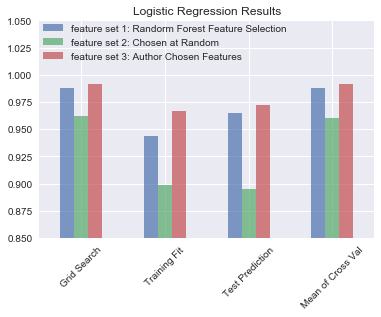

In [26]:
#Get scores set 1
score_lr_m1 = func_model_fit(logreg_set_1, train_x_1_ss, train_y_1_ss)
score_lr_m1_pred = func_model_pred(logreg_set_1, train_x_1_ss, train_y_1_ss, test_x_1_ss, test_y_1_ss)
cv_check_results_lr_1 = func_cv_check(logreg_set_1, train_x_1_ss, train_y_1_ss, x_1_ss, y_1_ss)
#build list for DataFrame for plot; feature set 1
lst_df_lr_set_1 =[]
lst_df_lr_set_1.append(logit_explore_1.best_score_)
lst_df_lr_set_1.append(score_lr_m1)
lst_df_lr_set_1.append(score_lr_m1_pred)
lst_df_lr_set_1.append(cv_check_results_lr_1.mean())
#Get scores set 2
score_lr_m2 = func_model_fit(logreg_set_2, train_x_2_ss, train_y_2_ss)
score_lr_m2_pred = func_model_pred(logreg_set_2, train_x_2_ss, train_y_2_ss, test_x_2_ss, test_y_2_ss)
cv_check_results_lr_2 = func_cv_check(logreg_set_2, train_x_2_ss, train_y_2_ss, x_2_ss, y_2_ss)
#build list for DataFrame for plot; feature set 2
lst_df_lr_set_2 =[]
lst_df_lr_set_2.append(logit_explore_2.best_score_)
lst_df_lr_set_2.append(score_lr_m2)
lst_df_lr_set_2.append(score_lr_m2_pred)
lst_df_lr_set_2.append(cv_check_results_lr_2.mean())
#Get scores set 3
score_lr_m3 = func_model_fit(logreg_set_3, train_x_3_ss, train_y_3_ss)
score_lr_m3_pred = func_model_pred(logreg_set_3, train_x_3_ss, train_y_3_ss, test_x_3_ss, test_y_3_ss)
cv_check_results_lr_3 = func_cv_check(logreg_set_3, train_x_3_ss, train_y_3_ss, x_3_ss, y_3_ss)
#build list for DataFrame for plot; feature set 3
lst_df_lr_set_3 =[]
lst_df_lr_set_3.append(logit_explore_3.best_score_)
lst_df_lr_set_3.append(score_lr_m3)
lst_df_lr_set_3.append(score_lr_m3_pred)
lst_df_lr_set_3.append(cv_check_results_lr_3.mean())
#Build df for plot
dct_for_lr_df = {'feature set 1: Randorm Forest Feature Selection': lst_df_lr_set_1,'feature set 2: Chosen at Random': lst_df_lr_set_2, 'feature set 3: Author Chosen Features': lst_df_lr_set_3}
df_for_lr_plot = pd.DataFrame(dct_for_lr_df, index=['Grid Search', 'Training Fit', 'Test Prediction', 'Mean of Cross Val'])
df_for_lr_plot.columns.name = 'modeling results'
#Plot the Data Frame for Logistic Regression
fig, axes = plt.subplots(1,1)
df_for_lr_plot.plot(kind='bar', ax=axes, alpha=0.7, title='Logistic Regression Results', ylim=[0.85, 1.05], rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

Below is the bar chart above, presented as a table. 

In [27]:
df_for_lr_plot

modeling results,feature set 1: Randorm Forest Feature Selection,feature set 2: Chosen at Random,feature set 3: Author Chosen Features
Grid Search,0.988343,0.962208,0.991882
Training Fit,0.943662,0.899061,0.967136
Test Prediction,0.965035,0.895105,0.972028
Mean of Cross Val,0.987906,0.960293,0.991889


Below is some feature ranking.

In [28]:
#Generalized Feature Ranking function. It is dependent on the type pf algorithm (not all algorithems have coef_)

def func_feature_rank_logit(x_full, model_fit, str_tag, out_tag, str_alg):
    lr_cols = []
    for col in x_full.columns:
        lr_cols.append(col + str_tag)
    lr_feature_importances = model_fit.coef_
    elem_1 = lr_feature_importances[0]
    df_out = pd.DataFrame({'Features_set': lr_cols, 'Importance Score': elem_1})
    df_out.sort_values('Importance Score', inplace=True, ascending=False)
    df_out.set_index(['Features_set'], inplace=True)
    print "Feature " + out_tag + " Ranking " + str_alg 
    return df_out

In [29]:
#Feature Set 1 Ranking
lr_fitted_set_1 = logreg_set_1.fit(train_x_1_ss, train_y_1_ss)
df_curr_lr_1 = func_feature_rank_logit(x_1, lr_fitted_set_1, '_f1', 'set 1', 'logit')
df_curr_lr_1.columns.name = 'Feature Set 1'
df_curr_lr_1

Feature set 1 Ranking logit


Feature Set 1,Importance Score
Features_set,
concave_points_worst_f1,1.526824
radius_worst_f1,1.190677
area_worst_f1,1.189251
perimeter_worst_f1,1.074821
concave_points_mean_f1,0.893001
Intercept_f1,-0.276983


In [30]:
lr_fitted_set_2 = logreg_set_2.fit(train_x_2_ss, train_y_2_ss)
df_curr_lr_2 = func_feature_rank_logit(x_2, lr_fitted_set_2, '_f2', 'set_2', 'logit')
df_curr_lr_2.columns.name = 'Feature Set 2'
df_curr_lr_2

Feature set_2 Ranking logit


Feature Set 2,Importance Score
Features_set,
perimeter_mean_f2,2.126808
radius_mean_f2,1.249829
texture_mean_f2,0.742991
Intercept_f2,-0.289374


In [31]:
lr_fitted_set_3 = logreg_set_3.fit(train_x_3_ss, train_y_3_ss)
df_curr_lr_3 = func_feature_rank_logit(x_3, lr_fitted_set_3, '_f3', 'set_3', 'logit')
df_curr_lr_3.columns.name = 'Feature Set 3'
df_curr_lr_3

Feature set_3 Ranking logit


Feature Set 3,Importance Score
Features_set,
area_worst_f3,5.913425
smoothness_worst_f3,1.391960
texture_mean_f3,0.824006
Intercept_f3,0.000000


In [32]:
#Using the training and test data, score the prediction (this will be passed to the confusion matrix)
def func_model_pred_conf(model, x_train, y_train, x_test):
    model_fit = model.fit(x_train, y_train)
    model_pred = model_fit.predict(x_test)
    return model_pred

In [33]:
#Two functions to handle the confusion matirx calculations- one to make a cm, the other to calculate and return a df
def mini_cm(c_matrix):
    t_pos = float(c_matrix[0,0])
    f_pos = float(c_matrix[0,1])
    f_neg = float(c_matrix[1,0])
    t_neg = float(c_matrix[1,1])
    lst_out = [t_pos, f_pos, f_neg, t_neg]
    return lst_out

def mini_cm_calc(test_y, cm_list):
    num_test = len(test_y)
    t_pos = cm_list[0]
    f_pos = cm_list[1]
    f_neg = cm_list[2]
    t_neg = cm_list[3]
    accuracy = ((t_pos + t_neg)/num_test)
    misclass = ((f_pos + f_neg)/num_test)
    precision = (t_pos / (t_pos + f_pos))
    recall = (t_pos / (t_pos + f_neg))
    lst_out = [accuracy, misclass, precision, recall]
    return lst_out

def func_cm_calc_to_df(test_y_1, c_matrix_1, test_y_2, c_matrix_2, test_y_3, c_matrix_3, lst_index, lst_cols):
    lst_cm_1 = mini_cm(c_matrix_1)
    lst_cm_calc_1 = mini_cm_calc(test_y_1, lst_cm_1)
    lst_cm_2 = mini_cm(c_matrix_2)
    lst_cm_calc_2 = mini_cm_calc(test_y_2, lst_cm_2)
    lst_cm_3 = mini_cm(c_matrix_3)
    lst_cm_calc_3 = mini_cm_calc(test_y_3, lst_cm_3)
    dct_for_df_out = {lst_cols[0]:lst_cm_calc_1, lst_cols[1]:lst_cm_calc_2, lst_cols[2]:lst_cm_calc_3}
    df_out = pd.DataFrame(dct_for_df_out, index=lst_index)
    df_out.reindex(columns=[lst_cols[0], lst_cols[1], lst_cols[2]])
    df_out.columns.name = 'Confusion Matrix Calculations'
    return df_out

In [34]:
#Function out puts a dataframe built from three different confusion matrices and a list of column names
def func_cm_to_df(c_matrix_1, c_matrix_2, c_matrix_3, lst_index, lst_cols):
    lst_for_df_1 = [c_matrix_1[0,0], c_matrix_1[0,1], c_matrix_1[1,0], c_matrix_1[1,1]]
    lst_for_df_2 = [c_matrix_2[0,0], c_matrix_2[0,1], c_matrix_2[1,0], c_matrix_2[1,1]]
    lst_for_df_3 = [c_matrix_3[0,0], c_matrix_3[0,1], c_matrix_3[1,0], c_matrix_3[1,1]]
    dct_for_df = {lst_cols[0]:lst_for_df_1, lst_cols[1]:lst_for_df_2, lst_cols[2]:lst_for_df_3}
    df_out = pd.DataFrame(dct_for_df, index=lst_index)
    df_out.columns.name = 'Confusion Matirx'
    return df_out

In [35]:
#Logistic Regression Confusion Matrix Results
#Critical to pass labels to the confusion matrix so that it gives the right results
#feature set 1
lr_model_pred_set_1 = func_model_pred_conf(logreg_set_1, train_x_1_ss, train_y_1_ss, test_x_1_ss)
conf_mat_lr_1 = confusion_matrix(test_y_1_ss, lr_model_pred_set_1, labels=[1,0])
#feature set 2
lr_model_pred_set_2 = func_model_pred_conf(logreg_set_2, train_x_2_ss, train_y_2_ss, test_x_2_ss)
conf_mat_lr_2 = confusion_matrix(test_y_2_ss, lr_model_pred_set_2, labels=[1,0])
#feature set 3
lr_model_pred_set_3 = func_model_pred_conf(logreg_set_3, train_x_3_ss, train_y_3_ss, test_x_3_ss)
conf_mat_lr_3 = confusion_matrix(test_y_3_ss, lr_model_pred_set_3, labels=[1,0])
#Build the df
lst_index = ['true_positive', 'false_positive', 'false_negative', 'true_negative']
lst_index_calc = ['accuracy', 'misclass', 'precision', 'recall']
lst_cols = ['Feature Set 1: RF', 'Feature Set 2: Random', 'Feature Set 3: Pre-Select']
df_for_lr_cm_plot = func_cm_to_df(conf_mat_lr_1, conf_mat_lr_2, conf_mat_lr_3, lst_index, lst_cols)
df_for_lr_cm_calc_plot = func_cm_calc_to_df(test_y_1, conf_mat_lr_1, test_y_2, conf_mat_lr_2, test_y_3, conf_mat_lr_3, lst_index_calc, lst_cols)


Below is the confusion matrix dataframe.

In [36]:
df_for_lr_cm_plot

Confusion Matirx,Feature Set 1: RF,Feature Set 2: Random,Feature Set 3: Pre-Select
true_positive,49,34,55
false_positive,3,10,4
false_negative,2,5,0
true_negative,89,94,84


Below are the calculaitons performed for the confusion matrix.

In [37]:
df_for_lr_cm_calc_plot

Confusion Matrix Calculations,Feature Set 1: RF,Feature Set 2: Random,Feature Set 3: Pre-Select
accuracy,0.965035,0.895105,0.972028
misclass,0.034965,0.104895,0.027972
precision,0.942308,0.772727,0.932203
recall,0.960784,0.871795,1.000000


Below, the bar chart displays the confusion matrix calculations (scoring?). Results look encouraging (probably not to be trusted).

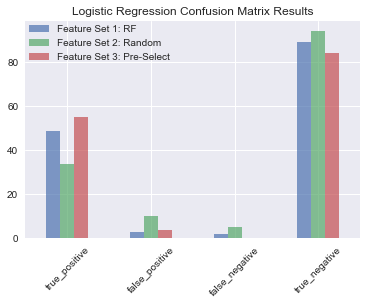

In [38]:
#Plot the Data Frame for Logistic Regression Confusion MAtrix
fig, axes = plt.subplots(1,1)
df_for_lr_cm_plot.plot(kind='bar', ax=axes, alpha=0.7, title='Logistic Regression Confusion Matrix Results', rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

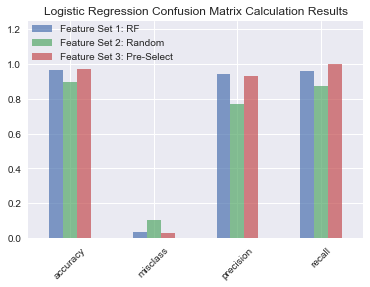

In [39]:
#Plot the Data Frame for Logistic Regression Confusion Matrix Calculation Results
fig, axes = plt.subplots(1,1)
df_for_lr_cm_calc_plot.plot(kind='bar', ax=axes, alpha=0.7, title='Logistic Regression Confusion Matrix Calculation Results', ylim=[0,1.25], rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

Same as above, but using the K-nearest neighboors classigication algorithm.

In [40]:
#KNN Model Exploration
kn_model_gs = KNeighborsClassifier()
kn_params = {"n_neighbors":[2,3,4,5,6], "weights":['uniform', 'distance'], "metric":['euclidean','minkowski']}

In [41]:
#K-Nearest Neighbors Model Exploration: feature set 1
knn_explore_1 = explore_model(kn_params, kn_model_gs, x_1, y_1)
print "K-Nearest Neighbors Model Exploration"
print "best gs params:"
print knn_explore_1.best_score_
print ""
print "best gs params:"
print knn_explore_1.best_params_

K-Nearest Neighbors Model Exploration
best gs params:
0.948627020156

best gs params:
{'n_neighbors': 6, 'metric': 'euclidean', 'weights': 'uniform'}


In [42]:
#K-Nearest Neighbors Model Exploration: feature set 2
knn_explore_2 = explore_model(kn_params, kn_model_gs, x_2, y_2)
print "K-Nearest Neighbors Model Exploration"
print "best gs params:"
print knn_explore_2.best_score_
print ""
print "best gs params:"
print knn_explore_2.best_params_

K-Nearest Neighbors Model Exploration
best gs params:
0.952121418447

best gs params:
{'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'uniform'}


In [43]:
#K-Nearest Neighbors Model Exploration: feature set 3
knn_explore_3 = explore_model(kn_params, kn_model_gs, x_3, y_3)
print "K-Nearest Neighbors Model Exploration"
print "best gs params:"
print knn_explore_3.best_score_
print ""
print "best gs params:"
print knn_explore_3.best_params_

K-Nearest Neighbors Model Exploration
best gs params:
0.953475475291

best gs params:
{'n_neighbors': 6, 'metric': 'euclidean', 'weights': 'distance'}


In [44]:
#Algorithm uses hyperparameters determined in GridSearch
#KNN for feature set 1 (uses train set fot fit and test set for predict)
knn_set_1 = KNeighborsClassifier(n_neighbors=6, metric='euclidean', weights='uniform')

print "K-Nearest Neighbors results:"
print "score of fit: " + str(func_model_fit(knn_set_1, train_x_1, train_y_1))
print "score of prediction: " + str(func_model_pred(knn_set_1, train_x_1, train_y_1, test_x_1, test_y_1))
#Cross Validation of the K-Nearest Neighbors (uses entire feature and training set)
print ""
print "K-Nearest Neighbors Cross validation results:"
cv_check_results_knn_1 = func_cv_check(knn_set_1, train_x_1, train_y_1, x_1, y_1)
print('CV AUC_1 {}, Average AUC_1 {}'.format(cv_check_results_knn_1, cv_check_results_knn_1.mean()))

K-Nearest Neighbors results:
score of fit: 0.913145539906
score of prediction: 0.965034965035

K-Nearest Neighbors Cross validation results:
CV AUC_1 [ 0.90891473  0.94234496  0.95657277  0.96763917  0.96847753], Average AUC_1 0.948789832015


In [45]:
#Algorithm uses hyperparameters determined in GridSearch
#KNN for feature set 2 (uses train set fot fit and test set for predict)
knn_set_2 = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')

print "K-Nearest Neighbors results:"
print "score of fit: " + str(func_model_fit(knn_set_2, train_x_2, train_y_2))
print "score of prediction: " + str(func_model_pred(knn_set_2, train_x_2, train_y_2, test_x_2, test_y_2))
#Cross Validation of the K-Nearest Neighbors (uses entire feature and training set)
print ""
print "K-Nearest Neighbors Cross validation results:"
cv_check_results_knn_2 = func_cv_check(knn_set_2, train_x_2, train_y_2, x_2, y_2)
print('CV AUC_2 {}, Average AUC_2 {}'.format(cv_check_results_knn_2, cv_check_results_knn_2.mean()))

K-Nearest Neighbors results:
score of fit: 0.927230046948
score of prediction: 0.888111888112

K-Nearest Neighbors Cross validation results:
CV AUC_2 [ 0.92070413  0.93104005  0.97904091  0.95472837  0.9760228 ], Average AUC_2 0.952307254379


In [46]:
#Algorithm uses hyperparameters determined in GridSearch
#KNN for feature set 3 (uses train set fot fit and test set for predict)
knn_set_3 = KNeighborsClassifier(n_neighbors=6, metric='euclidean', weights='distance')

print "K-Nearest Neighbors results:"
print "score of fit: " + str(func_model_fit(knn_set_3, train_x_3, train_y_3))
print "score of prediction: " + str(func_model_pred(knn_set_3, train_x_3, train_y_3, test_x_3, test_y_3))
#Cross Validation of the K-Nearest Neighbors (uses entire feature and training set)
print ""
print "K-Nearest Neighbors Cross validation results:"
cv_check_results_knn_3 = func_cv_check(knn_set_3, train_x_3, train_y_3, x_3, y_3)
print('CV AUC_3 {}, Average AUC_3 {}'.format(cv_check_results_knn_3, cv_check_results_knn_3.mean()))

K-Nearest Neighbors results:
score of fit: 1.0
score of prediction: 0.902097902098

K-Nearest Neighbors Cross validation results:
CV AUC_3 [ 0.90487726  0.9496124   0.97954393  0.96227364  0.97199866], Average AUC_3 0.95366117896


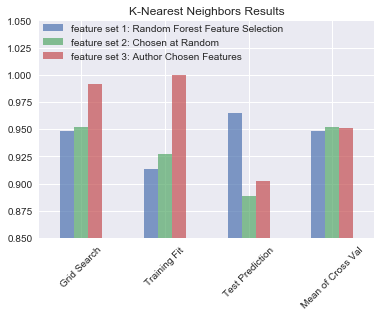

In [47]:
#Get scores set 1
score_knn_m1 = func_model_fit(knn_set_1, train_x_1, train_y_1)
score_knn_m1_pred = func_model_pred(knn_set_1, train_x_1, train_y_1, test_x_1, test_y_1)
cv_check_results_knn_1 = func_cv_check(knn_set_1, train_x_1, train_y_1, x_1, y_1)
#build list for DataFrame for plot; feature set 1
lst_df_kn_set_1 =[]
lst_df_kn_set_1.append(knn_explore_1.best_score_)
lst_df_kn_set_1.append(score_knn_m1)
lst_df_kn_set_1.append(score_knn_m1_pred)
lst_df_kn_set_1.append(cv_check_results_knn_1.mean())
#Get scores set 2
score_knn_m2 = func_model_fit(knn_set_2, train_x_2, train_y_2)
score_knn_m2_pred = func_model_pred(knn_set_2, train_x_2, train_y_2, test_x_2, test_y_2)
cv_check_results_knn_2 = func_cv_check(knn_set_2, train_x_2, train_y_2, x_2, y_2)
#build list for DataFrame for plot; feature set 2
lst_df_kn_set_2 =[]
lst_df_kn_set_2.append(knn_explore_2.best_score_)
lst_df_kn_set_2.append(score_knn_m2)
lst_df_kn_set_2.append(score_knn_m2_pred)
lst_df_kn_set_2.append(cv_check_results_knn_2.mean())
#Get scores set 3
score_knn_m3 = func_model_fit(knn_set_3, train_x_3, train_y_3)
score_knn_m3_pred = func_model_pred(knn_set_3, train_x_3, train_y_3, test_x_3, test_y_3)
cv_check_results_knn_3 = func_cv_check(knn_set_3, train_x_3, train_y_3, x_2, y_3)
#build list for DataFrame for plot; feature set 3
lst_df_kn_set_3 =[]
lst_df_kn_set_3.append(logit_explore_3.best_score_)
lst_df_kn_set_3.append(score_knn_m3)
lst_df_kn_set_3.append(score_knn_m3_pred)
lst_df_kn_set_3.append(cv_check_results_knn_3.mean())
#Build df for plot
dct_for_kn_df = {'feature set 1: Random Forest Feature Selection': lst_df_kn_set_1,'feature set 2: Chosen at Random': lst_df_kn_set_2, 'feature set 3: Author Chosen Features': lst_df_kn_set_3}
df_for_kn_plot = pd.DataFrame(dct_for_kn_df, index=['Grid Search', 'Training Fit', 'Test Prediction', 'Mean of Cross Val'])
df_for_kn_plot.columns.name = 'knn modeling results'
#Plot the Data Frame for KNN Results
fig, axes = plt.subplots(1,1)
df_for_kn_plot.plot(kind='bar', ax=axes, alpha=0.7, title='K-Nearest Neighbors Results', ylim=[0.85, 1.05], rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

In [48]:
df_for_kn_plot

knn modeling results,feature set 1: Random Forest Feature Selection,feature set 2: Chosen at Random,feature set 3: Author Chosen Features
Grid Search,0.948627,0.952121,0.991882
Training Fit,0.913146,0.927230,1.000000
Test Prediction,0.965035,0.888112,0.902098
Mean of Cross Val,0.948790,0.952307,0.951240


In [49]:
#K-Nearest Neighbors Confusion Matrix Results
#Critical to pass labels to the confusion matrix so that it gives the right results
#feature set 1
knn_model_pred_set_1 = func_model_pred_conf(knn_set_1, train_x_1, train_y_1, test_x_1)
conf_mat_knn_1 = confusion_matrix(test_y_1, knn_model_pred_set_1, labels=[1,0])
#feature set 2
knn_model_pred_set_2 = func_model_pred_conf(knn_set_2, train_x_2, train_y_2, test_x_2)
conf_mat_knn_2 = confusion_matrix(test_y_2, knn_model_pred_set_2, labels=[1,0])
#feature set 3
knn_model_pred_set_3 = func_model_pred_conf(knn_set_3, train_x_3, train_y_3, test_x_3)
conf_mat_knn_3 = confusion_matrix(test_y_3, knn_model_pred_set_3, labels=[1,0])
#Build the df
lst_index = ['true_positive', 'false_positive', 'false_negative', 'true_negative']
lst_index_calc = ['accuracy', 'misclass', 'precision', 'recall']
lst_cols = ['Feature Set 1: RF', 'Feature Set 2: Random', 'Feature Set 3: Pre-Select']
df_for_knn_cm_plot = func_cm_to_df(conf_mat_knn_1, conf_mat_knn_2, conf_mat_knn_3, lst_index, lst_cols)
df_for_knn_cm_calc_plot = func_cm_calc_to_df(test_y_1, conf_mat_knn_1, test_y_2, conf_mat_knn_2, test_y_3, conf_mat_knn_3, lst_index_calc, lst_cols)


In [50]:
df_for_knn_cm_plot

Confusion Matirx,Feature Set 1: RF,Feature Set 2: Random,Feature Set 3: Pre-Select
true_positive,44,37,47
false_positive,4,11,7
false_negative,1,5,7
true_negative,94,90,82


In [51]:
df_for_knn_cm_calc_plot

Confusion Matrix Calculations,Feature Set 1: RF,Feature Set 2: Random,Feature Set 3: Pre-Select
accuracy,0.965035,0.888112,0.902098
misclass,0.034965,0.111888,0.097902
precision,0.916667,0.770833,0.870370
recall,0.977778,0.880952,0.870370


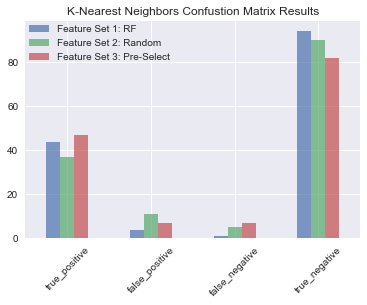

In [52]:
fig, axes = plt.subplots(1,1)
df_for_knn_cm_plot.plot(kind='bar', ax=axes, alpha=0.7, title='K-Nearest Neighbors Confustion Matrix Results', rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

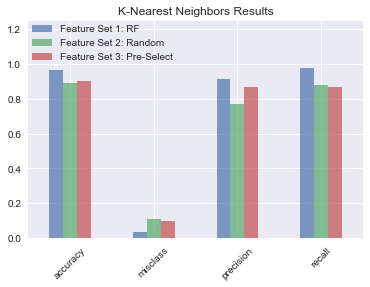

In [53]:
fig, axes = plt.subplots(1,1)
df_for_knn_cm_calc_plot.plot(kind='bar', ax=axes, alpha=0.7, title='K-Nearest Neighbors Results', ylim=[0, 1.25], rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

In [54]:
#Random Forrest Model Exploration
rf_model_gs = RandomForestClassifier()
rf_params = {"n_estimators":[10,50,100,500], 'max_depth':[3,4,5,6,7,8]}

In [55]:
#Random Forrest Model Exploration: feature set 1
rnd_frst_explore_1 = explore_model(rf_params, rf_model_gs, x_1, y_1)
print "Random ForrestNeighbors Model Exploration"
print "best gs params:"
print rnd_frst_explore_1.best_score_
print ""
print "best gs params: "
print rnd_frst_explore_1.best_params_

Random ForrestNeighbors Model Exploration
best gs params:
0.987193604697

best gs params: 
{'n_estimators': 10, 'max_depth': 4}


In [56]:
#Random Forrest Model Exploration: feature set 2
rnd_frst_explore_2 = explore_model(rf_params, rf_model_gs, x_2, y_2)
print "Random ForrestNeighbors Model Exploration"
print "best gs params:"
print rnd_frst_explore_2.best_score_
print ""
print "best gs params: "
print rnd_frst_explore_2.best_params_

Random ForrestNeighbors Model Exploration
best gs params:
0.964675626818

best gs params: 
{'n_estimators': 500, 'max_depth': 8}


In [57]:
#Random Forrest Model Exploration: feature set 3
rnd_frst_explore_3 = explore_model(rf_params, rf_model_gs, x_3, y_3)
print "Random ForrestNeighbors Model Exploration"
print "best gs params:"
print rnd_frst_explore_3.best_score_
print ""
print "best gs params: "
print rnd_frst_explore_3.best_params_

Random ForrestNeighbors Model Exploration
best gs params:
0.991309862074

best gs params: 
{'n_estimators': 50, 'max_depth': 7}


In [58]:
#Algorithm uses hyperparameters determined in GridSearch
#Random Forrest for feature set 1 (uses train set fot fit and test set for predict)
rnd_frst_set_1 = RandomForestClassifier(n_estimators=100, max_depth=3)

print "Random Forrest results:"
print "score of fit: " + str(func_model_fit(rnd_frst_set_1, train_x_1, train_y_1))
print "score of prediction: " + str(func_model_pred(rnd_frst_set_1, train_x_1, train_y_1, test_x_1, test_y_1))
#Cross Validation of the Random Forres (uses entire feature and training set)
print ""
print "Random Forres Cross validation results:"
cv_check_results_rf_1 = func_cv_check(rnd_frst_set_1, train_x_1, train_y_1, x_1, y_1)
print('CV AUC_1 {}, Average AUC_1 {}'.format(cv_check_results_rf_1, cv_check_results_rf_1.mean()))

Random Forrest results:
score of fit: 0.953051643192
score of prediction: 0.986013986014

Random Forres Cross validation results:
CV AUC_1 [ 0.9744832   0.98126615  0.99429913  0.98239437  0.99496982], Average AUC_1 0.985482533444


In [59]:
#Algorithm uses hyperparameters determined in GridSearch
#Random Forrest for feature set 2 (uses train set fot fit and test set for predict)
rnd_frst_set_2 = RandomForestClassifier(n_estimators=500, max_depth=7)

print "Random Forrest results:"
print "score of fit: " + str(func_model_fit(rnd_frst_set_2, train_x_2, train_y_2))
print "score of prediction: " + str(func_model_pred(rnd_frst_set_2, train_x_2, train_y_2, test_x_2, test_y_2))
#Cross Validation of the Random Forres (uses entire feature and training set)
print ""
print "Random Forres Cross validation results:"
cv_check_results_rf_2 = func_cv_check(rnd_frst_set_2, train_x_2, train_y_2, x_2, y_2)
print('CV AUC_2 {}, Average AUC_2 {}'.format(cv_check_results_rf_2, cv_check_results_rf_2.mean()))

Random Forrest results:
score of fit: 0.988262910798
score of prediction: 0.902097902098

Random Forres Cross validation results:
CV AUC_2 [ 0.92829457  0.95671835  0.97853789  0.96814219  0.98423877], Average AUC_2 0.963186353262


In [60]:
#Algorithm uses hyperparameters determined in GridSearch
#Random Forrest for feature set 3 (uses train set fot fit and test set for predict)
rnd_frst_set_3 = RandomForestClassifier(n_estimators=50, max_depth=5)

print "Random Forrest results:"
print "score of fit: " + str(func_model_fit(rnd_frst_set_3, train_x_3, train_y_3))
print "score of prediction: " + str(func_model_pred(rnd_frst_set_3, train_x_3, train_y_3, test_x_3, test_y_3))
#Cross Validation of the Random Forres (uses entire feature and training set)
print ""
print "Random Forres Cross validation results:"
cv_check_results_rf_3 = func_cv_check(rnd_frst_set_3, train_x_3, train_y_3, x_3, y_3)
print('CV AUC_3 {}, Average AUC_3 {}'.format(cv_check_results_rf_3, cv_check_results_rf_3.mean()))

Random Forrest results:
score of fit: 0.995305164319
score of prediction: 0.979020979021

Random Forres Cross validation results:
CV AUC_3 [ 0.98191214  0.97787468  0.99765258  0.97686117  0.9963112 ], Average AUC_3 0.986122354281


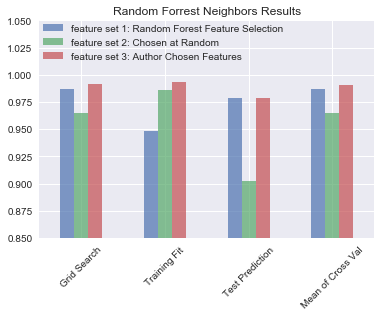

In [61]:
#Get scores set 1
score_rnd_frst_m1 = func_model_fit(rnd_frst_set_1, train_x_1, train_y_1)
score_rnd_frst_m1_pred = func_model_pred(rnd_frst_set_1, train_x_1, train_y_1, test_x_1, test_y_1)
cv_check_results_rf_1 = func_cv_check(rnd_frst_set_1, train_x_1, train_y_1, x_1, y_1)
#build list for DataFrame for plot; feature set 1
lst_df_rnd_frst_set_1 =[]
lst_df_rnd_frst_set_1.append(rnd_frst_explore_1.best_score_)
lst_df_rnd_frst_set_1.append(score_rnd_frst_m1)
lst_df_rnd_frst_set_1.append(score_rnd_frst_m1_pred)
lst_df_rnd_frst_set_1.append(cv_check_results_rf_1.mean())
#Get scores set 2
score_rnd_frst_m2 = func_model_fit(rnd_frst_set_2, train_x_2, train_y_2)
score_rnd_frst_m2_pred = func_model_pred(rnd_frst_set_2, train_x_2, train_y_2, test_x_2, test_y_2)
cv_check_results_rf_2 = func_cv_check(rnd_frst_set_2, train_x_2, train_y_2, x_2, y_2)
#build list for DataFrame for plot; feature set 2
lst_df_rnd_frst_set_2 =[]
lst_df_rnd_frst_set_2.append(rnd_frst_explore_2.best_score_)
lst_df_rnd_frst_set_2.append(score_rnd_frst_m2)
lst_df_rnd_frst_set_2.append(score_rnd_frst_m2_pred)
lst_df_rnd_frst_set_2.append(cv_check_results_rf_2.mean())
#Get scores set 3
score_rnd_frst_m3 = func_model_fit(rnd_frst_set_3, train_x_3, train_y_3)
score_rnd_frst_m3_pred = func_model_pred(rnd_frst_set_3, train_x_3, train_y_3, test_x_3, test_y_3)
cv_check_results_rf_3 = func_cv_check(rnd_frst_set_3, train_x_3, train_y_3, x_3, y_3)
#build list for DataFrame for plot; feature set 3
lst_df_rnd_frst_set_3 =[]
lst_df_rnd_frst_set_3.append(rnd_frst_explore_3.best_score_)
lst_df_rnd_frst_set_3.append(score_rnd_frst_m3)
lst_df_rnd_frst_set_3.append(score_rnd_frst_m3_pred)
lst_df_rnd_frst_set_3.append(cv_check_results_rf_3.mean())
#Build df for plot
dct_for_rnd_frst_df = {'feature set 1: Random Forest Feature Selection': lst_df_rnd_frst_set_1,'feature set 2: Chosen at Random': lst_df_rnd_frst_set_2, 'feature set 3: Author Chosen Features': lst_df_rnd_frst_set_3}
df_for_rnd_frst_plot = pd.DataFrame(dct_for_rnd_frst_df, index=['Grid Search', 'Training Fit', 'Test Prediction', 'Mean of Cross Val'])
df_for_rnd_frst_plot.columns.name = 'Random Forrest modeling results'
#Plot the Data Frame for Random Forrest
fig, axes = plt.subplots(1,1)
df_for_rnd_frst_plot.plot(kind='bar', ax=axes, alpha=0.7, title='Random Forrest Neighbors Results', ylim=[0.85, 1.05], rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

In [62]:
df_for_rnd_frst_plot

Random Forrest modeling results,feature set 1: Random Forest Feature Selection,feature set 2: Chosen at Random,feature set 3: Author Chosen Features
Grid Search,0.987194,0.964676,0.991310
Training Fit,0.948357,0.985915,0.992958
Test Prediction,0.979021,0.902098,0.979021
Mean of Cross Val,0.986542,0.964675,0.990858


In [63]:
#Generalized Feature Ranking function. It is dependent on the type pf algorithm (not all algorithems have coef_)

def func_feature_rank_rnd_frst(x_full, model_fit, str_tag, out_tag, str_alg):
    rf_cols = []
    for col in x_full.columns:
        rf_cols.append(col + str_tag)
    rf_feature_importances = model_fit.feature_importances_
    df_out = pd.DataFrame({'Features_set': rf_cols, 'Importance Score': rf_feature_importances})
    df_out.sort_values('Importance Score', inplace=True, ascending=False)
    df_out.set_index(['Features_set'], inplace=True)
    print "Feature " + out_tag + " Ranking " + str_alg 
    return df_out

In [64]:
#Feature Set 1 Ranking
rf_fitted_set_1 = rnd_frst_set_1.fit(train_x_1, train_y_1)
df_curr_rf_1 = func_feature_rank_rnd_frst(x_1, rf_fitted_set_1, '_f1', 'set 1', 'random_forest')
df_curr_rf_1.columns.name = 'Feature Set 1'
df_curr_rf_1

Feature set 1 Ranking random_forest


Feature Set 1,Importance Score
Features_set,
concave_points_mean_f1,0.255002
concave_points_worst_f1,0.246410
perimeter_worst_f1,0.228624
area_worst_f1,0.154633
radius_worst_f1,0.115330
Intercept_f1,0.000000


In [65]:
#Feature Set 2 Ranking
rf_fitted_set_2 = rnd_frst_set_2.fit(train_x_2, train_y_2)
df_curr_rf_2 = func_feature_rank_rnd_frst(x_2, rf_fitted_set_2, '_f2', 'set 2', 'random_forest')
df_curr_rf_2.columns.name = 'Feature Set 2'
df_curr_rf_2

Feature set 2 Ranking random_forest


Feature Set 2,Importance Score
Features_set,
perimeter_mean_f2,0.461541
radius_mean_f2,0.372012
texture_mean_f2,0.166447
Intercept_f2,0.000000


In [66]:
#Feature Set 3 Ranking
rf_fitted_set_3 = rnd_frst_set_3.fit(train_x_3, train_y_3)
df_curr_rf_3 = func_feature_rank_rnd_frst(x_3, rf_fitted_set_3, '_f3', 'set 3', 'random_forest')
df_curr_rf_3.columns.name = 'Feature Set 3'
df_curr_rf_3

Feature set 3 Ranking random_forest


Feature Set 3,Importance Score
Features_set,
area_worst_f3,0.679264
texture_mean_f3,0.178572
smoothness_worst_f3,0.142164
Intercept_f3,0.000000


In [67]:
#Logistic Regression Confusion Matrix Results
#Critical to pass labels to the confusion matrix so that it gives the right results
#feature set 1
rnd_frst_model_pred_set_1 = func_model_pred_conf(rnd_frst_set_1, train_x_1, train_y_1, test_x_1)
conf_mat_rnd_frst_1 = confusion_matrix(test_y_1, rnd_frst_model_pred_set_1, labels=[1,0])
#feature set 2
rnd_frst_model_pred_set_2 = func_model_pred_conf(rnd_frst_set_2, train_x_2, train_y_2, test_x_2)
conf_mat_rnd_frst_2 = confusion_matrix(test_y_2, rnd_frst_model_pred_set_2, labels=[1,0])
#feature set 3
rnd_frst_model_pred_set_3 = func_model_pred_conf(rnd_frst_set_3, train_x_3, train_y_3, test_x_3)
conf_mat_rnd_frst_3 = confusion_matrix(test_y_3, rnd_frst_model_pred_set_3, labels=[1,0])
#Build the df
lst_index = ['true_positive', 'false_positive', 'false_negative', 'true_negative']
lst_index_calc = ['accuracy', 'misclass', 'precision', 'recall']
lst_cols = ['Feature set 1:RF', 'Feature Set 2: Random', 'Feature Set 3: Pre-Select']
df_for_rnd_frst_cm_plot = func_cm_to_df(conf_mat_rnd_frst_1, conf_mat_rnd_frst_2, conf_mat_rnd_frst_3, lst_index, lst_cols)
df_for_rnd_frst_cm_calc_plot = func_cm_calc_to_df(test_y_1, conf_mat_rnd_frst_1, test_y_2, conf_mat_rnd_frst_2, test_y_3, conf_mat_rnd_frst_3, lst_index_calc, lst_cols)


In [68]:
df_for_rnd_frst_cm_plot 

Confusion Matirx,Feature Set 2: Random,Feature Set 3: Pre-Select,Feature set 1:RF
true_positive,38,51,47
false_positive,10,3,1
false_negative,4,0,1
true_negative,91,89,94


In [69]:
df_for_rnd_frst_cm_calc_plot

Confusion Matrix Calculations,Feature Set 2: Random,Feature Set 3: Pre-Select,Feature set 1:RF
accuracy,0.902098,0.979021,0.986014
misclass,0.097902,0.020979,0.013986
precision,0.791667,0.944444,0.979167
recall,0.904762,1.000000,0.979167


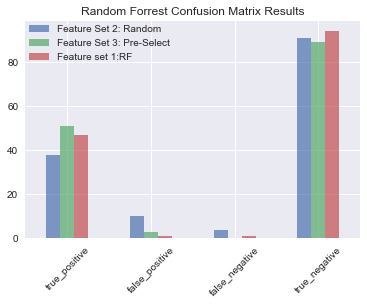

In [70]:
#Plot the Data Frame for Random Forrest Confusion Matrix
fig, axes = plt.subplots(1,1)
df_for_rnd_frst_cm_plot.plot(kind='bar', ax=axes, alpha=0.7, title='Random Forrest Confusion Matrix Results', rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)

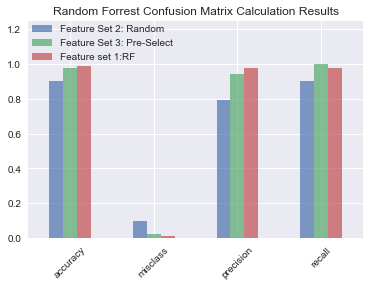

In [71]:
#Plot the Data Frame for Random Forrest Confusion Matrix
fig, axes = plt.subplots(1,1)
df_for_rnd_frst_cm_calc_plot.plot(kind='bar', ax=axes, alpha=0.7, title='Random Forrest Confusion Matrix Calculation Results', ylim=[0,1.25], rot=45)
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)